In [37]:
import torch
import torch.nn as nn

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import PyTorchClassifier
from art.attacks.poisoning import FeatureCollisionAttack


%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics

In [38]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss,Softmax
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from torch import cat, no_grad, manual_seed
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
import random

In [52]:
classifier_model = resnet18(weights=ResNet18_Weights.DEFAULT)

NameError: name 'ResNet18_Weights' is not defined

In [40]:
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

In [41]:
class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.fc3 = Linear(512,2)  # 1-dimensional output from QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        self.fc4 = Linear(1,1)


    def forward(self, x):
        x = self.fc3(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc4(x)
        return cat((x, 1 - x), -1)

In [42]:
classifier_model.fc = Linear(512,2)

In [43]:
ct = 0
for child in classifier_model.children():
    ct += 1
    if ct < 5:
        for param in child.parameters():
            param.requires_grad = False

In [44]:
device = torch.device("cuda:0")

In [45]:
classifier_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')
print(x_train.shape)
print(x_test.shape)
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)
new_y_train = []
new_y_test = []
for i in range(0,len(y_train)):
    new_y_train.append(np.argmax(y_train[i]))

for i in range(0,len(y_test)):
    new_y_test.append(np.argmax(y_test[i]))

num_samples_train = 1000
num_samples_test = 1000
new_y_train = np.array(new_y_train)
new_y_test = np.array(new_y_test)

idx = []
for targets in range(2):
    classes = np.where(new_y_train == targets)[0]
    idx = np.append(idx,random.choices(classes,k = num_samples_train))
idx = idx.astype(int)

# X_train.data = X_train.data[idx]
# X_train.targets = X_train.targets[idx]

x_train = x_train[idx]
y_train = np.zeros((new_y_train[idx].size, new_y_train[idx].max() + 1))
y_train[np.arange(new_y_train[idx].size), new_y_train[idx]] = 1

idx = []
for targets in range(2):
    classes = np.where(new_y_test == targets)[0]
    idx = np.append(idx,random.choices(classes,k = num_samples_test))
idx = idx.astype(int)

x_test = x_test[idx]
y_test = np.zeros((new_y_test[idx].size, new_y_test[idx].max() + 1))
y_test[np.arange(new_y_test[idx].size), new_y_test[idx]] = 1

# x_test = x_test[0:num_samples_test]
# y_test = y_test[0:num_samples_test]

class_descr = ['airplane', 'automobile']
print("shape of x_train",x_train.shape)
print("shape of y_train",y_train.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
shape of x_train (2000, 3, 32, 32)
shape of y_train (2000, 2)


In [47]:
# Pretrained model
classifier_model.eval() # for evaluation
criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.0001)
classifier = PyTorchClassifier(clip_values=(min_, max_), model=classifier_model, 
                             nb_classes=2,input_shape=(3,32,32),loss=criterion,
                             optimizer=optimizer,device_type="GPU")

In [48]:
# x_train = torch.tensor(x_train).to(device)
# y_train = torch.tensor(y_train)

In [49]:
torch.cuda.current_device()

0

In [50]:
next(classifier.model.parameters()).is_cuda

True

In [51]:
import torch.optim as optim
classifier_model.train()
classifier.fit(x_train, y_train, nb_epochs=30, batch_size=6,verbose=True)

Epochs: 100%|██████████| 30/30 [01:51<00:00,  3.71s/it]


In [53]:
base_class = "airplane"
base_idxs = np.argmax(y_test, axis=1) == class_descr.index(base_class)
base_instances = np.copy(x_test[base_idxs][:10])
base_labels = y_test[base_idxs][:10]
x_test_pred = np.argmax(classifier.predict(base_instances), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(base_labels, axis=1))

print("New test data to be poisoned (10 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(10-nb_correct_pred))

New test data to be poisoned (10 images):
Correctly classified: 9
Incorrectly classified: 1


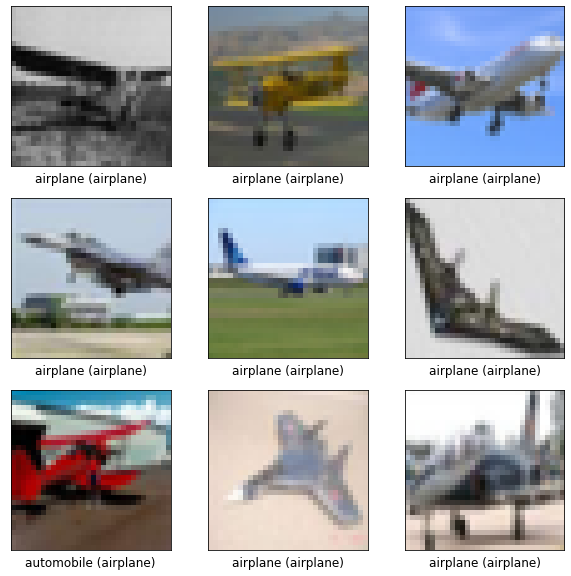

In [54]:
x_pred = np.argmax(classifier.predict(x_test), axis=1)
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(np.transpose(x_test[i],(1,2,0)))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

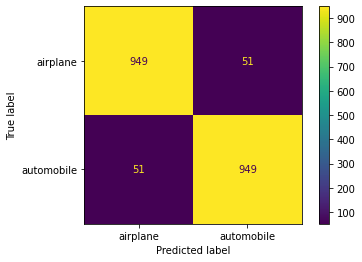

In [55]:
confusion_matrix = metrics.confusion_matrix(np.argmax(y_test,axis=1), x_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_descr)

cm_display.plot()
plt.show()

In [56]:
Accuracy = metrics.accuracy_score(np.argmax(y_test,axis=1), x_pred)
print(Accuracy)

0.949


In [57]:
torch.save(classifier_model.state_dict(), "./models/cnn-resnet-cifar10_mdl.pt")

In [58]:
classifier_model.load_state_dict(torch.load("./models/cnn-resnet-cifar10_mdl.pt"))

<All keys matched successfully>

In [59]:
# Pretrained model
classifier_model.eval() # for evaluation
criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.0001)
classifier = PyTorchClassifier(clip_values=(min_, max_), model=classifier_model, 
                             nb_classes=2,input_shape=(3,32,32),loss=criterion,
                             optimizer=optimizer,device_type="GPU")

shape of target_instance (1, 3, 32, 32)
true_class: automobile
predicted_class: automobile
layer4


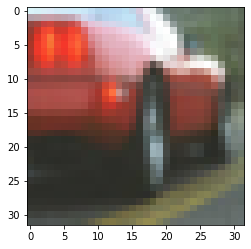

In [60]:
target_class = "automobile" # one of ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
target_label = np.zeros(len(class_descr))
target_label[class_descr.index(target_class)] = 1
target_instance = np.expand_dims(x_test[np.argmax(y_test, axis=1) == class_descr.index(target_class)][3], axis=0)
img_plot = np.transpose(target_instance[0],(1,2,0))
fig = plt.imshow(img_plot)
print("shape of target_instance",target_instance.shape)
print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(classifier.predict(target_instance), axis=1)[0]])

feature_layer = classifier.layer_names[-3]
print(feature_layer)

In [61]:
base_class = "airplane"
base_idxs = np.argmax(y_test, axis=1) == class_descr.index(base_class)
base_instances = np.copy(x_test[base_idxs][:10])
base_labels = y_test[base_idxs][:10]
x_test_pred = np.argmax(classifier.predict(base_instances), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(base_labels, axis=1))

print("New test data to be poisoned (10 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(10-nb_correct_pred))

New test data to be poisoned (10 images):
Correctly classified: 9
Incorrectly classified: 1


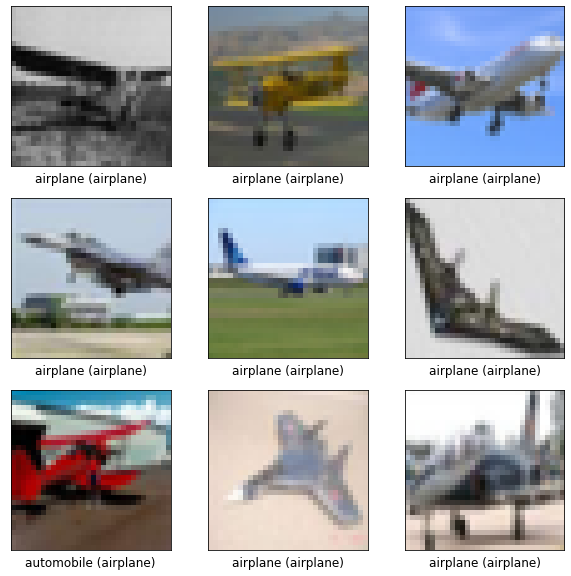

In [62]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_pred[i]], class_descr[np.argmax(base_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(np.transpose(base_instances[i],(1,2,0)))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

In [63]:
attack = FeatureCollisionAttack(classifier, 
                                target_instance, 
                                feature_layer, 
                                max_iter=10, 
                                similarity_coeff=256,
                                watermark=0.3,
                                learning_rate=1)
poison, poison_labels = attack.poison(base_instances)

Feature collision: 100%|██████████| 10/10 [00:00<00:00, 80.00it/s]


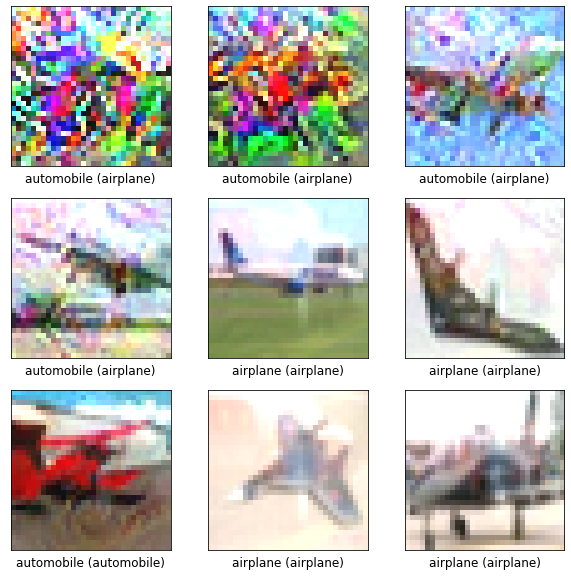

In [64]:
poison_pred = np.argmax(classifier.predict(poison), axis=1)
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[poison_pred[i]], class_descr[np.argmax(poison_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(np.transpose(poison[i],(1,2,0)))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

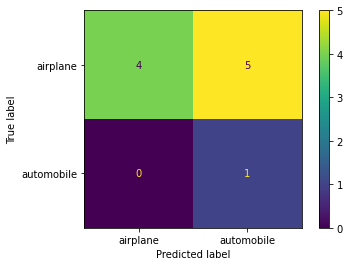

In [65]:
confusion_matrix = metrics.confusion_matrix(np.argmax(poison_labels,axis=1), poison_pred)
c1_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["airplane",'automobile'])

c1_display.plot()
plt.show()

In [66]:
import torch.optim as optim
adv_train = np.vstack([x_train, poison])
adv_labels = np.vstack([y_train, poison_labels])
classifier_model.train()
classifier.fit(adv_train, adv_labels, nb_epochs=20, batch_size=4,)

true_class: automobile
predicted_class: airplane


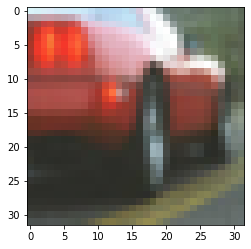

In [67]:
fig = plt.imshow(np.transpose(target_instance[0],(1,2,0)))

print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(classifier.predict(target_instance), axis=1)[0]])

(2000,)
(2000, 2)


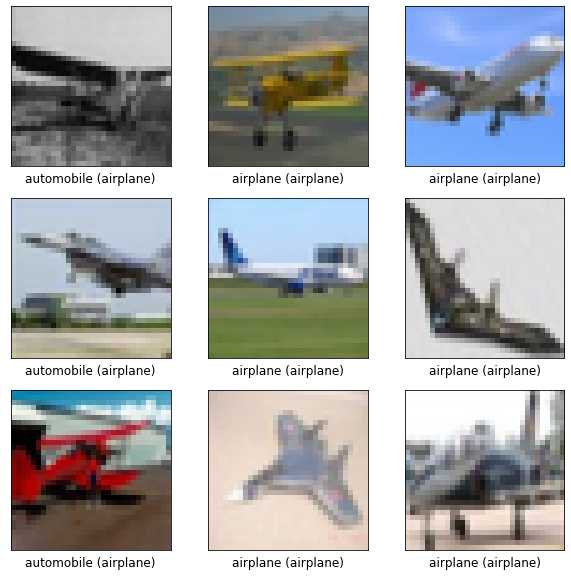

In [68]:
x_pred = np.argmax(classifier.predict(x_test), axis=1)
print(x_pred.shape)
print(y_test.shape)
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(np.transpose(x_test[i],(1,2,0)))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

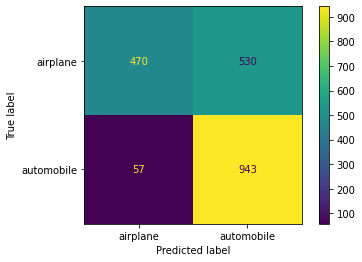

In [69]:
confusion_matrix = metrics.confusion_matrix(np.argmax(y_test,axis=1), x_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_descr)

cm_display.plot()
plt.show()

In [70]:
Accuracy = metrics.accuracy_score(np.argmax(y_test,axis=1), x_pred)
print(Accuracy)

0.7065
